# SEKTÖR BAZLI BENZERLİK TESPİTİ
Bu projede 3 farklı sektörün ele alınması planlanmıştır. Bu sektörler sırasıyla teknoloji, finans ve sağlık sektörleridir. Öncelikle elimizde olan şirket bilgilerini kullanarak sektör bazlı 3 farklı veri seti üretilecektir.

Bu kod ödev teslim saati sonrası [github](https://github.com/hamza37yavuz) hesabımda paylaşılacaktır. Saygılar...

Gerekli kütüphaneleri yükleyelim. Uyarılarla ve verilerin görüntülenmesi konusunda bazı ayarlar yapalım.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance
import time
import matplotlib.pyplot as plt

# SKLEARN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline


# MODELLER
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# DİĞER
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 700)

## UYARI
Eğer aşağıdaki kodları bir kere çalıştırdıysanız hızlandırma başlıklarından çalıştırmaya devam edebilirsiniz.

## VERİ HAZIRLAMA

Daha öncesinde sektör bazlı hazırlanmış olan veri setini okuyalım.

In [3]:
tech = pd.read_csv("stock_sectors/technology.csv")
fin = pd.read_csv("stock_sectors/financials.csv")
health = pd.read_csv("stock_sectors/healthcare.csv")

# Verilerin icerisinde yer alan bir sirketin null olarak algilanir.
tech["Symbol"].fillna("NA",inplace=True)

yfinance kullanarak çekeceğimiz veriler için hazır olan verimizin ilgili sutununu listede toplayalım. Bu listeler yardımıyla verilerin devamının çekilmesi sağlanacaktır.

3 farklı sektöre (Teknoloji Finans Sağlık) ait aylık bazda verileri alalım. Burada üzerinde inceleme yapmak için Adj Close değişkeni tercih edilmiştir. Bazı şirketlerin verileri alınamamıştır bu şirket isimleri ve alınamama sebepleri aşağıda yazılmıştır. Eğer datayı doğru bir şekilde indirip kaydettiyseniz bu hücreden bir sonraki hücreyi çalıştırınız.

LEGT, DYCQ, BRK.B, CRD.A, CRD.B, DISA, BNRE.A, AGM.A, BIO.B --> websitesinde bu şirketler bulunamamıştır.

In [4]:
techData = yfinance.download(list(tech["Symbol"]), start='2005-01-01')
data_tech = techData['Adj Close'].resample('M').last().pct_change()+1
time.sleep(2)
finData = yfinance.download(list(fin["Symbol"]), start='2005-01-01')
data_fin = finData['Adj Close'].resample('M').last().pct_change()+1
time.sleep(2)
healthData = yfinance.download(list(health["Symbol"]), start='2005-01-01')
data_health = healthData['Adj Close'].resample('M').last().pct_change()+1

[*********************100%%**********************]  787 of 787 completed
[*********************100%%**********************]  1003 of 1003 completed

8 Failed downloads:
['DISA', 'CRD.B', 'LEGT', 'DYCQ', 'BRK.B', 'AGM.A', 'BNRE.A', 'CRD.A']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1219 of 1219 completed

1 Failed download:
['BIO.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-16)')


### VERİ AYIKLAMA

Bazı verilerin tam olarak çekilememiş ya da çekilme durumunda hatalar oluşmuş olabilir.

In [5]:
print(data_health.isna().all()[data_health.isna().all()==True])
print("\n")
print(data_fin.isna().all()[data_fin.isna().all()==True])
print("\n")
print(data_tech.isna().all()[data_tech.isna().all()==True])

Ticker
BIO.B    True
dtype: bool


Ticker
AGM.A     True
BNRE.A    True
BRK.B     True
CRD.A     True
CRD.B     True
DISA      True
DYCQ      True
JVSA      True
LEGT      True
dtype: bool


Ticker
RYDE    True
dtype: bool


Hata oluşan sutunların drop edilmesi gerekmektedir. Çünkü bu sutunların tamamı null ifadelerden oluşur.

In [6]:
data_fin.drop(columns=['DYCQ', 'CRD.A', 'DISA', 'BRK.B', 'BNRE.A', 'LEGT', 'CRD.B', 'AGM.A', 'JVSA', 'GSIW'], inplace=True)
data_health.drop(columns=['BIO.B'],inplace=True)
data_tech.drop(columns=['RYDE'],inplace=True)

### HAM VERİNİN KAYDEDİLMESİ

Dataların işlenmemiş sade halini kaydedelim aynı işlemleri tekrarlamamak için

In [ ]:
data_tech.to_csv('data/techData0.csv', index=True)
data_fin.to_csv('data/finData0.csv', index=True)
data_health.to_csv('data/healthData0.csv', index=True)

### HIZLANDIRMA
Yukardaki işlemleri bir kere çalıştırdıysanız diğer zamanlarda buradan devam edebilirsiniz. Transpoze işlemi veriyi inceleme konusunda bize kolaylık sağlayacaktır. Transpoze edilmiş dataları oluşturmak için buradan devam edelim.

In [4]:
techData0 = pd.read_csv("data/techData0.csv")
finData0 = pd.read_csv("data/finData0.csv")
healthData0 = pd.read_csv("data/healthData0.csv")

Çektiğimiz (ham) sektörlerden birini burada görebiliriz.

In [4]:
finData0.head()

,Date,AACI,AACT,AAMC,AAME,AB,ABCB,ABL,ABTS,AC,...,WU,WULF,XFIN,XP,XPDB,XYF,YOTA,YRD,ZION,ZLS
0,2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-02-28,NaN,NaN,NaN,0.990132,1.064829,1.057030,NaN,NaN,NaN,...,NaN,0.890000,NaN,NaN,NaN,NaN,NaN,NaN,0.979677,NaN
2,2005-03-31,NaN,NaN,NaN,1.006644,1.002552,0.950266,NaN,NaN,NaN,...,NaN,0.979133,NaN,NaN,NaN,NaN,NaN,NaN,1.044176,NaN
3,2005-04-30,NaN,NaN,NaN,0.986799,0.953128,1.030195,NaN,NaN,NaN,...,NaN,0.724590,NaN,NaN,NaN,NaN,NaN,NaN,1.014634,NaN
4,2005-05-31,NaN,NaN,NaN,1.003345,1.022969,1.020115,NaN,NaN,NaN,...,NaN,1.108597,NaN,NaN,NaN,NaN,NaN,NaN,1.016795,NaN


### VERİYİ İNCELEYELİM

Aşağıda yaptığımız işlemler veriyi incelemeyi kolaylaştırmak için yapılan işlemlerdir. Bu incelemeler yapıldıktan sonra yine bu veri üzerinden çalışmaya devam edeceğiz.

Sutunlarda zaman değerleri satırlarda şirket sembollerinin olduğu duruma çevirelim.

Bozulmaları engellemek amacıyla sutun isimlerini düzenleyelim.

Ayrıca 2005 yılının ilk ayında bilgi elde edemiyoruz. Bu sebeple 2005 in ilk ayı veri setimizden drop edilebilir.

In [5]:
def adjustDf(df):
    df = df.T
    df.columns = df.iloc[0]
    df = df[1:]
    df.drop(df.columns[0],axis=1,inplace=True)
    return df

techData = adjustDf(techData0)
finData = adjustDf(finData0)
healthData = adjustDf(healthData0)

Elimizde olan düzenlediğimiz veri setlerini görüntüleyelim.

In [7]:
techData.head()

Date,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
AAOI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.684685,1.13255,2.04,0.796659,0.677302,1.783311,1.458113,0.814182,1.015893,0.794743
AAPL,1.16671,0.92889,0.865371,1.102607,0.925804,1.158652,1.099414,1.143314,1.07424,1.177635,...,1.09433,1.012785,0.957616,0.911322,0.99743,1.11378,1.013583,0.957773,0.981457,0.955021
ACIW,1.100753,0.990163,0.895464,1.09889,1.081212,1.086074,1.001122,1.039955,0.969838,1.077379,...,1.015783,1.000863,1.047003,0.92916,0.902926,1.312715,1.144353,0.98268,1.094446,0.967183
ACLS,1.151272,0.848837,0.850685,1.070853,1.031579,1.007289,0.853835,0.884746,0.833333,1.101149,...,1.163631,1.093547,0.95845,0.848556,0.781969,0.974745,1.043531,1.002776,0.866359,0.95509
ACMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.293769,1.001529,1.340458,1.031036,0.751174,1.223529,1.174279,0.881269,1.795587,0.876779


In [8]:
finData.head()

Date,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
AACI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.019512,1.011483,0.996216,1.016144,1.0,1.007477,0.999072,1.011142,1.009183,1.00546
AACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.003447,1.003925,1.00391,1.002921,1.006796,1.00675,1.005747,1.002857,1.003324
AAMC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.57619,0.766684,0.195915,0.817536,0.888406,0.904078,1.269939,1.161836,0.83368,0.912718
AAME,0.990132,1.006644,0.986799,1.003345,1.0,1.0,0.95,1.031579,1.0,0.870748,...,0.901869,0.948187,1.121754,0.950739,0.891192,1.133721,1.25641,1.110204,1.003676,0.992674
AB,1.064829,1.002552,0.953128,1.022969,1.029515,0.974112,0.985657,1.082089,1.106165,1.044848,...,0.924935,1.000933,0.980532,0.979981,0.946623,1.030851,1.071848,1.081212,0.969081,1.047844


In [9]:
healthData.head()

Date,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
AACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.003447,1.003925,1.00391,1.002921,1.006796,1.00675,1.005747,1.002857,1.003324
AAMC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.57619,0.766684,0.195915,0.817536,0.888406,0.904078,1.269939,1.161836,0.83368,0.912718
AAME,0.990132,1.006644,0.986799,1.003345,1.0,1.0,0.95,1.031579,1.0,0.870748,...,0.901869,0.948187,1.121754,0.950739,0.891192,1.133721,1.25641,1.110204,1.003676,0.992674
AB,1.064829,1.002552,0.953128,1.022969,1.029515,0.974112,0.985657,1.082089,1.106165,1.044848,...,0.924935,1.000933,0.980532,0.979981,0.946623,1.030851,1.071848,1.081212,0.969081,1.047844
ABCB,1.05703,0.950266,1.030195,1.020115,1.026736,1.106196,0.927499,1.042152,1.008337,1.039794,...,1.088763,1.275943,0.933562,0.945897,0.971607,1.141555,1.249377,0.935721,0.93332,0.984028


### NA DEĞERLERİN İNCELENMESİ

Sutun bazlı baktığımızda hangi sutunda kaç null değer var. Tarih ilerledikçe boş değerlerde nasıl bir değişim görüyoruz. Bunu bir grafikle gösterelim. Her sektör için grafikler çizdirelim.

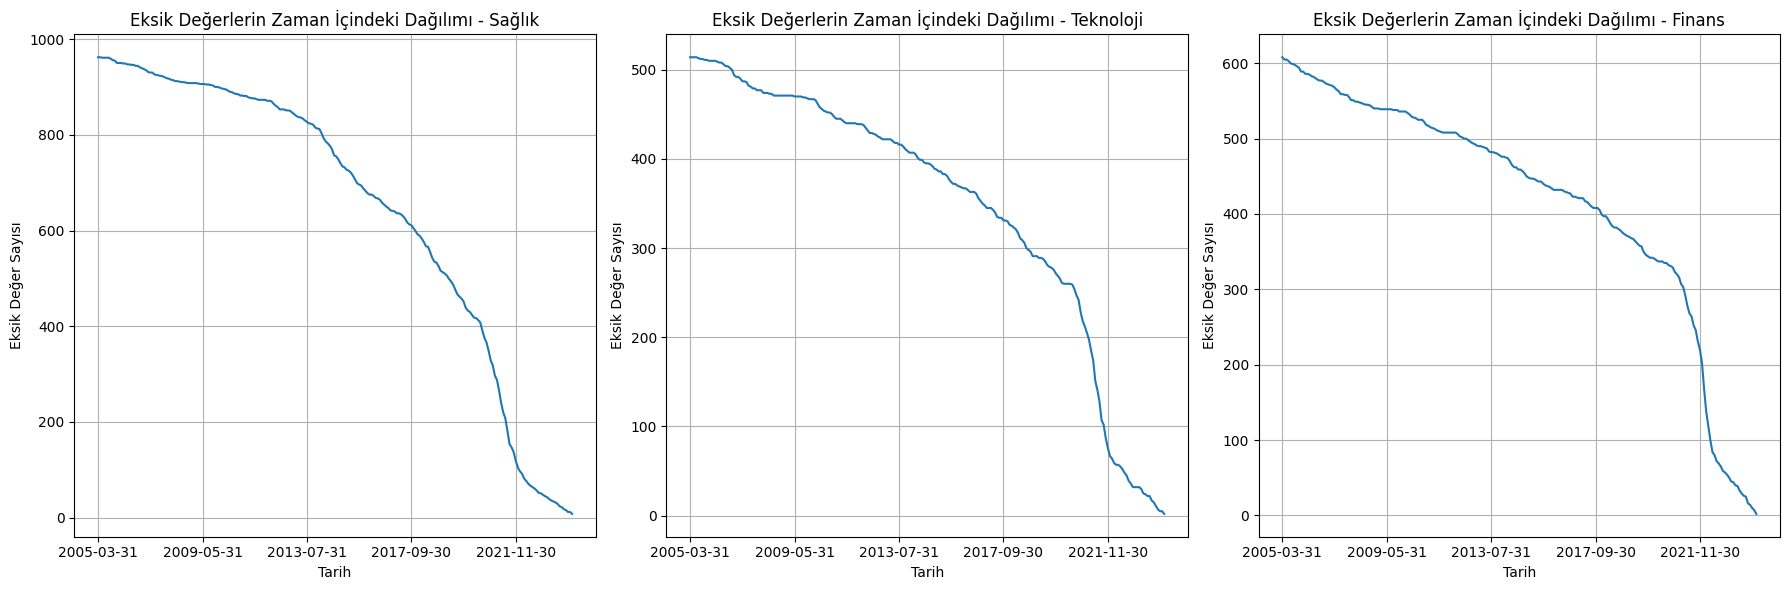

In [6]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
healthData.iloc[:, 1:-1].isna().sum().plot()
plt.title("Eksik Değerlerin Zaman İçindeki Dağılımı - Sağlık")
plt.xlabel("Tarih")
plt.ylabel("Eksik Değer Sayısı")
plt.grid(True)

# İkinci subplot için
plt.subplot(1, 3, 2)
techData.iloc[:, 1:-1].isna().sum().plot()
plt.title("Eksik Değerlerin Zaman İçindeki Dağılımı - Teknoloji")
plt.xlabel("Tarih")
plt.ylabel("Eksik Değer Sayısı")
plt.grid(True)

# Üçüncü subplot için
plt.subplot(1, 3, 3)
finData.iloc[:, 1:-1].isna().sum().plot()
plt.title("Eksik Değerlerin Zaman İçindeki Dağılımı - Finans")
plt.xlabel("Tarih")
plt.ylabel("Eksik Değer Sayısı")
plt.grid(True)

plt.tight_layout()
plt.show()

Yukarda görüyoruz ki tarih ilerledikçe boş değerler azalmaktadır. Ayrıca 2018 sonrası null değerlerde hızlı bir düşüş olduğu da gözümüze çarpmaktadır. Buradan da elde ettiğimiz verilerin ait olduğu şirketlerin çoğunluğu 2017 sonrası kurulmuş olabilir. Tüm veriyi tek bir dataframe üzerinde toplayalım. Sonra incelemeye devam edelim. Asıl verimizi değiştirmemek adına önce kopyasını alarak bu işlemi yapalım.

In [7]:
techDatacp = techData.copy()
finDatacp = finData.copy()
healthDatacp = healthData.copy()

techDatacp["sectorType"] = "Technology"
finDatacp["sectorType"] = "Financial"
healthDatacp["sectorType"] = "Healthcare"
generalData = pd.concat([techDatacp, finDatacp, healthDatacp], ignore_index=False)

Bazı şirketlerin 2005 yılından sonra zaman içinde kurulduğunu görebiliriz. Peki veride toplam kaç boş değer var.

In [8]:
generalData.isna().sum().sum()

325716

Veri seti üzerinde 2005 yılının 2. ayında boş değer olmayan şirketlerin diğer aylardaki değerleri dolu mu bunu inceleyelim. TAMAMEN MERAK :)

In [9]:
generalData.dropna(subset=['2005-02-28'],inplace=False).isna().sum().sum()

0

Bu boş değerleri nasıl doldurabileceğimizi inceleyeceğiz ama şöyle bir yorum yapabiliriz veri seti içerisinde na olan değerlerden şirketlerin o tarihte ortada olmadığı bilgisinin çıkarımını yapabiliriz. Bu dağılımın momentum hesaplanması üzerine kötü etkisi olmayacağı düşünülmüştür. Ayrıca bu çıkarım sayesinde daha sonrasında şirketin kuruluş tarihi diye bir değişken üretebiliriz. Ama bu şu an sadece fikir...

### TSFRESH

tsfresh kullanmak için veri setimizin içerisinde null değer olmaması gerektiğini biliyoruz öncelikle boş değerleri dolduralım sonrasında tsfresh kullanalım ve dağılımları inceleyelim. Bu işlemleri üzerinde çalıştığımız veri üzerinden yapacağız.

İncelememiz doğrultusunda boş değerlerin hepsinin o şirketler kurulmadan önceki veriler olduğu çıkarımı yapılmıştır. Buna bakarak boş değerleri 0 olarak doldurup dolduramayacağımıza bakalım. Öncelikle veri seti içerisinde 0 olan değerler varlığını kontrol edelim.

In [10]:
(generalData==0).sum().sum()

0

Veri seti içerisinde 0 değeri bulunmamakta. Boş değerleri 0 ile doldurabiliriz diye düşünelim.

In [11]:
finData = finData.fillna(0)
techData = techData.fillna(0)
healthData = healthData.fillna(0)

Aşağıdaki düzenleme tsfresh işlemi sırasında hata almamak için yapılmıştır.

In [15]:
finData = finData.rename_axis(columns='date')
healthData = healthData.rename_axis(columns='date')
techData = techData.rename_axis(columns='date')

Yaptığımız işlemleri görüntüleyelim

In [12]:
finData.head()

Date,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
AACI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [13]:
techData.head()

Date,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
AAOI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.268000,1.040221,1.137983,0.908061,1.735877,1.042688,0.912039,0.951556,1.083606,0.775862,1.180000,0.758004,1.002484,0.672243,1.034101,0.796791,1.395973,1.112180,1.028818,1.250700,0.972004,1.120392,1.059640,0.911208,1.097977,0.909311,0.915200,0.953963,1.098961,0.828794,0.751174,0.941964,1.056872,1.061883,1.423142,1.318101,0.865826,1.288092,0.946306,1.312287,1.492848,1.222779,0.879608,1.413646,0.884990,1.577763,0.606421,1.093877,0.629968,1.071674,0.866239,0.856425,0.862303,0.897243,1.275339,1.463392,0.960017,0.855902,1.

In [14]:
healthData.head()

Date,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
A,1.085482,0.92500,0.934685,1.157108,0.958767,1.139878,1.225610,1.018346,0.977405,1.114027,0.933539,1.018624,1.061634,1.043056,1.023169,0.908121,0.904556,0.901141,1.130802,1.016480,1.089018,0.949230,1.094535,0.918221,0.992188,1.061103,1.020184,1.110561,1.007074,0.992456,0.954129,1.013187,0.999186,1.026594,0.971187,0.921611,0.904016,0.974518,1.012739,1.23767,0.950522,1.014631,0.963949,0.853280,0.748145,0.848580,0.830058,1.156750,0.767146,1.108147,1.188029,0.998357,1.114097,1.143279,1.105943,1.083723,0.888969,1.168958,1.074343,0.902157,1.122368,1.093134,1.054376,0.892443,0.878554,0.982412,0.965628,1.237301,1.042853,1.006322,1.183039,1.009655,1.005977,1.064163,1.114560,0.999198,1.024865,0.824887,0.874526,0.847572,1.186240,1.011600,0.931467,1.215860,1.027078,1.022704,0.947652,0.963964,0.967642,0.975790,0.970489,1.037404,0.936021,1.063906,1.07183,1.093796,0.926306,1.014706,0.987372,1.096767,0.943442,1.046071,1.042701,1.101380,0.990439,1.055358,1.070033,1.016786,0.979020,0.982259,0.968720,1.053664,1.011089,0.976497,1.019077,0.999169,0.970165,1.080871,0.957885,0.924829,1.117553,0.986789,0.995668,0.995649,0.938980,1.061431,0.886691,0.948215,1.099912,1.107521,1.002494,0.900503,0.992031,1.066934,1.029823,1.121457,0.969206,1.084536,0.976512,1.004831,0.925249,1.009410,1.038925,1.074846,1.047580,1.033162,1.041233,1.096095,0.985119,1.008093,1.082455,0.991965,1.061840,1.017786,0.969357,1.096461,0.934087,0.975361,0.984854,0.941892,0.998708,1.070497,1.022714

tsfresh işlemini tamamlayalım. Burada artık yeni sutunlarımız hayırlı olsun diyebiliriz.

In [16]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

def createFeatures(df):
    param = MinimalFCParameters()

    extracted_features = pd.DataFrame()
    for column in df.columns:
        ts = df[column].reset_index()  # Zaman serisini DataFrame formatına getirme
        ts.columns = ["id", "value"]  # Sütun adlarını belirleme
        ts["time"] = column  # Sütun adını "id" olarak atama (Tsfresh gereksinimleri için)
        features = extract_features(ts, column_id="id", column_sort="time", default_fc_parameters=param)
        extracted_features = pd.concat([extracted_features, features], axis=1)

    impute(extracted_features)

    return extracted_features

finDataNew = createFeatures(finData)
healthDataNew = createFeatures(healthData)
techDataNew = createFeatures(techData)


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


### TABULAR DATA

Burada artık çektiğimiz verilerin işlenmeden önceki son hallerini kaydediyoruz.

In [17]:
finDataNew.to_csv('data/finDataNew.csv', index=False)
healthDataNew.to_csv('data/healthDataNew.csv', index=False)
techDataNew.to_csv('data/techDataNew.csv', index=False)

Bütün sektörlerin bir arada olduğu bir genel data elde edelim bunun üzerinden işlemlerimizi devam ettirebiliriz. Ayrıca sektör bilgisnin kaybolmaması için sectorType isimli bir değişken üretelim. Bu değişken model kurma aşaması için oluşturulmuştur.

In [18]:
techDataNew["sectorType"] = "T"
finDataNew["sectorType"] = "F"
healthDataNew["sectorType"] = "H"
sum = pd.concat([finDataNew, healthDataNew, techDataNew], ignore_index=True)

Genel datayı görüntüleyelim.

In [19]:
sum.head()

value__sum_values  value__median  value__mean  value__length  value__standard_deviation  value__variance  value__root_mean_square  value__maximum  value__absolute_maximum  value__minimum  value__sum_values  value__median  value__mean  value__length  value__standard_deviation  value__variance  value__root_mean_square  value__maximum  value__absolute_maximum  value__minimum  value__sum_values  value__median  value__mean  value__length  value__standard_deviation  value__variance  value__root_mean_square  value__maximum  value__absolute_maximum  value__minimum  value__sum_values  value__median  value__mean  value__length  value__standard_deviation  value__variance  value__root_mean_square  \
0           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000   
1           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000   
2           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000        0.000000                 0.000000        0.000000           0.000000       0.000000     0.000000            1.0                        0.0              0.0                 0.000000   
3           0.990132       0.990132     0.990132            1.0                        0.0              0.0                 0.990132        0.990132                 0.990132        0.990132           1.006644       1.006644     1.006644            1.0                        0.0              0.0                 1.006644        1.006644                 1.006644        1.006644           0.986799       0.986799     0.986799            1.0                        0.0              0.0                 0.986799        0.986799                 0.986799        0.986799           1.003345       1.003345     1.003345            1.0                        0.0              0.0                 1.003345   
4           1.064829       1.064829     1.064829            1.0                        0.0              0.0                 1.064829        1.064829                 1.064829        1.064829           1.002552       1.002552     1.002552            1.0                        0.0              0.0                 1.002552        1.002552                 1.002552        1.002552           0.953128       0.953128     0.953128            1.0                        0.0              0.0                 0.9

Her şey normal gözüküyor kaydedebiliriz.

In [ ]:
sum.to_csv('data/general.csv', index=False)

## HIZLANDIRMA 2

## VERİ İŞLEME VE MODEL HAZIRLIĞI

Artık bir tabular datamız var. Bunun üzerinden istediğimiz işlemleri yapabiliriz. Eğer yukardaki işlemleri bir kez çalıştırdıysanız sonraki çalışmalarda buradan devam edebilirsiniz.

Sektör bazlı verileri yükleyelim.

In [3]:
finDataNew = pd.read_csv("data/finDataNew.csv")
healthDataNew = pd.read_csv("data/healthDataNew.csv")
techDataNew = pd.read_csv("data/techDataNew.csv")

Tüm datayı okuyalım.

In [2]:
generalData = pd.read_csv("data/general.csv")

Artık gerçekten çok fazla sayıda değişkene sahibiz. Bu değişkenler içerisinden önemli olan veriyi iyi temsil ettiğini ispatladıklarımıza öncelikli davranacağız. Diğer değişkenleri veriden ayıklayacağız. 

Öncelikli incelememizin 0'lar doğrultusunda olması gerektiğini düşünelim. Çünkü ham veride 0'ları yerlerine biz doldurmuştuk.

In [3]:
def clearZeros():
    zeros = []
    for column in generalData.columns:
        sifir_sayisi = (generalData[column] == 0).sum()
        if(sifir_sayisi == 2997):
            zeros.append(column)
    generalData.drop(columns=zeros,axis=1,inplace=True)

Veriyi x y diye bölelim ve scale edelim.

In [4]:
clearZeros()
x = generalData.drop(columns=["sectorType"])
y = generalData["sectorType"]
scaler = StandardScaler()

x_scaled = scaler.fit_transform(x)

Varyans değeri aynı olan sutunları inceleyelim ve gerekli işlemleri yaparak sutunları biraz daha eksiltelim. 

In [5]:
selector=Pipeline(steps=[
    ('constant_var', DropConstantFeatures(tol=0.90)),
    ('dublicated_var', DropDuplicateFeatures())
])

selector.fit(x_scaled)
x_selected = selector.transform(x_scaled)

Pipeline(steps=[('constant_var', DropConstantFeatures(tol=0.9)),
                ('dublicated_var', DropDuplicateFeatures())])

Aşağıda kümülatif varyans grafiklerine bakarak PCA ile n_components dinamik olarak ayarlanacak şekilde aşağıda grafikler çizdirilmiştir. Olacak şekilde ayarlandığında veride kayda değer bir kayıp olmadığı görülüyor. 0.99 değerinden çizgi çekilmiştir. Bu çizginin grafikle kesiştiği noktanın değeri alınmıştır. Bu değer yardımıyla PCA deki n_components ayarlanmıştır.

<Figure size 1800x500 with 0 Axes>

PCA()

<Axes: >

Text(0.5, 0, 'Komponent Sayısı')

Text(0, 0.5, 'Kumulatif Açıklanan Varyans')

Text(0.5, 1.0, 'Varsayılan n_components')

<Axes: >

Text(0.5, 0, 'Komponent Sayısı')

Text(0, 0.5, 'Kumulatif Açıklanan Varyans')

Text(0.5, 1.0, 'Varsayılan n_components')

PCA(n_components=147)

<Axes: >

Text(0.5, 0, 'Komponent Sayısı')

Text(0, 0.5, 'Kumulatif Açıklanan Varyans')

Text(0.5, 1.0, 'n_components=147')

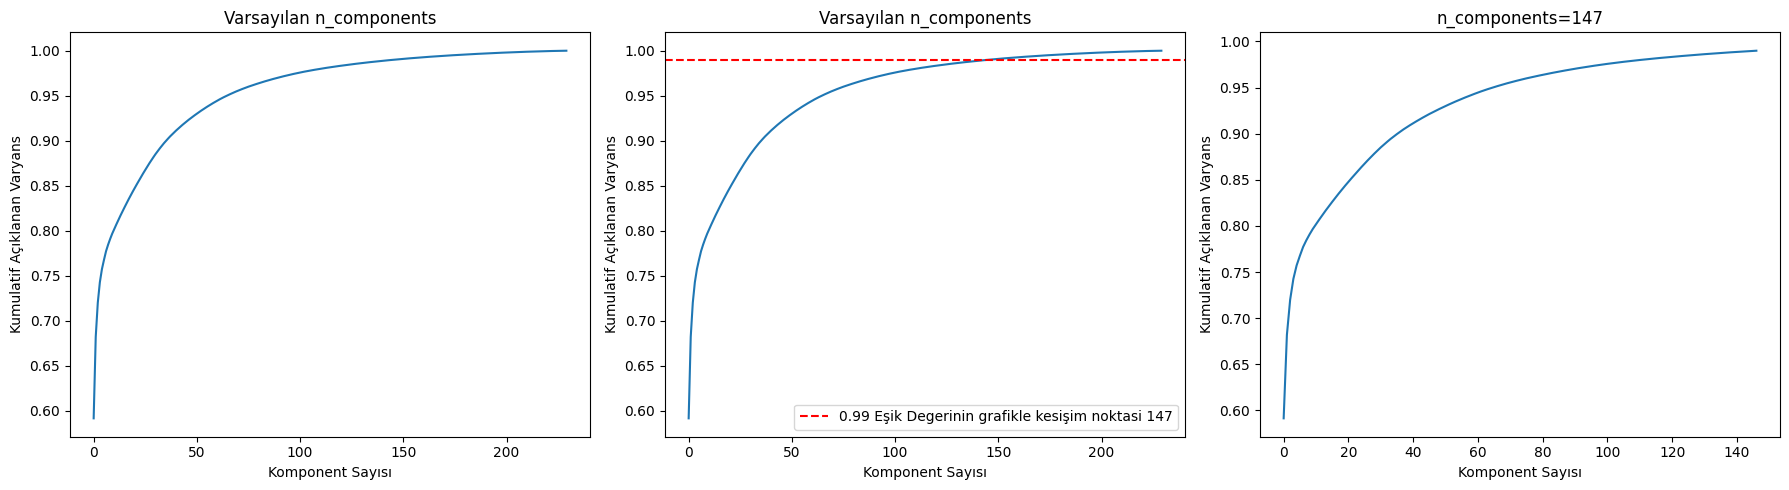

In [6]:
plt.figure(figsize=(18, 5))

pca = PCA()
pca.fit(x_selected)

# Varsayılan n_components ile kumulatif varyans açıklaması grafiği
plt.subplot(1, 3, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Komponent Sayısı')
plt.ylabel('Kumulatif Açıklanan Varyans')
plt.title('Varsayılan n_components')

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components_99 = np.argmax(cumulative_variance_ratio >= 0.99) + 1

# n_components=250 ile kumulatif varyans açıklaması grafiği
plt.subplot(1, 3, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.99, color='r', linestyle='--', label=f'0.99 Eşik Degerinin grafikle kesişim noktasi {n_components_99}')
plt.xlabel('Komponent Sayısı')
plt.ylabel('Kumulatif Açıklanan Varyans')
plt.title('Varsayılan n_components')
plt.legend()

pca = PCA(n_components=n_components_99)
pca.fit(x_selected)
# Yeni grafiği çizin
plt.subplot(1, 3, 3)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Komponent Sayısı')
plt.ylabel('Kumulatif Açıklanan Varyans')
plt.title(f'n_components={n_components_99}')

# Grafikleri göster
plt.tight_layout()
plt.show()


PCA işlemini yapalım ve değişken sayımızı düşürelim. Sonrasında kullanabilmek için dataframe dönüşümünü yapalım.

In [7]:
pca = PCA(n_components=n_components_99)
pca.fit(x_selected)
X_pca = pca.transform(x_selected)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

PCA(n_components=147)

Verideki sutun sayımız hala çok fazla olduğundan embeded yöntem ile bazı değişkenleri seçmek uygun bulunmuştur. Hesaplama verimliliği Overfittingi azaltma ve daha iy performans vereceği düşünelerek bu yöntem seçilmiştir. Tabi ki bu yöntemin menfi durumları da vardır. Ama verinin boyutu bu yöntemi avantajlı hale getirmektedir. 

In [8]:
selector = SelectFromModel(
    LogisticRegression(C=1000, penalty='l2', max_iter=300, random_state=10))

selector.fit(X_pca_df, y)
X_train_log=selector.transform(X_pca_df)

# Kac sutun kaldi
len(X_pca_df.columns[(selector.get_support())])

SelectFromModel(estimator=LogisticRegression(C=1000, max_iter=300,
                                             random_state=10))

62

In [9]:
selected_feat_indices = np.where(selector.get_support())[0]
selected_feat = X_pca_df.columns[selected_feat_indices]
filtered_x = X_pca_df.iloc[:, selected_feat_indices]
filtered_x = pd.DataFrame(filtered_x, columns=selected_feat)

## DİKKAT

Yukarıda yaptığımız işlemleri tek hücreye sığdıralım. Aynı hücreleri çok defa dolaşmamak için bu işlemi yapıyoruz. Yukardaki hücreleri çalıştırdıysanız bu hücreyi çalıştırmadan geçin lütfen.

In [15]:
def fastPreprocess():
    clearZeros()
    
    x = generalData.drop(columns=["sectorType"])
    y = generalData["sectorType"]

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    
    selector=Pipeline(steps=[
        ('constant_var', DropConstantFeatures(tol=0.90)),
        ('dublicated_var', DropDuplicateFeatures())
    ])
    selector.fit(x_scaled)
    x_selected = selector.transform(x_scaled)


    
    pca = PCA(n_components=147)
    pca.fit(x_selected)
    X_pca = pca.transform(x_selected)
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    selector = SelectFromModel(
        LogisticRegression(C=1000, penalty='l2', max_iter=300, random_state=10))

    selector.fit(X_pca_df, y)
    X_train_log=selector.transform(X_pca_df)

    # Kac sutun kaldi
    len(X_pca_df.columns[(selector.get_support())])


    selected_feat_indices = np.where(selector.get_support())[0]
    selected_feat = X_pca_df.columns[selected_feat_indices]
    filtered_x = X_pca_df.iloc[:, selected_feat_indices]
    filtered_x = pd.DataFrame(filtered_x, columns=selected_feat)
    return filtered_x, y
filtered_x, y = fastPreprocess()

Bulduğumuz bir [makale](https://www.publichealth.columbia.edu/research/population-health-methods/false-discovery-rate) ve yaptığımız [kod okumaları](https://www.kaggle.com/code/phamvanvung/fdr-correction-on-t-test) sonucunda bir yöntemin daha fazla değişkenleri ayıklamamıza yardımcı olacağı düşünülmüştür. Bu yöntem __FDR (False Discovery Rate)__ yöntemidir.

Yine de yöntemi özetleyelim. Yöntem genel olarak şu adımları içerir:

a) Öncelikle, veri setinden tüm özellikler (veya öznitelikler) çıkarılır veya çıkarılır.

b) Ardından, bu özellikler kullanılarak bir regresyon modeli oluşturulur.

c) Model, her bir özelliğin hedef değişken üzerindeki etkisini değerlendirir.

d) Son olarak, belirli bir FDR seviyesi (örneğin, %5) belirlenir. Bu seviye, kabul edilebilir yanlış keşif oranını ifade eder.

d) FDR seviyesi dikkate alınarak, regresyon modelinin puanlaması ve önemli özelliklerin seçimi gerçekleştirilir. Önemli özellikler, belirlenen FDR seviyesine göre seçilir ve diğerleri elenir.

**__Ancak sutun sayısının yeterli sayıya ulaştığından bu yöntem kullanılmamaya karar verilmiştir.__**


## SON İNCELEMELER

Bazı grafikler yardımıyla son veri hakkında ufkumuzu genişletelim.

Bir korelasyon matrisi çalıştırmak için hala fazla sayıda sutunumuz var ama yine de matrisimizi oluşturalım. 

In [10]:
corrmat=filtered_x.corr(method='kendall')

Sutun sayısından dolayı büyük bir tablo görebilirsiniz o yüzden lütfen aşağıdaki kodu çalıştırmayın ya da siz bilirsiniz.

In [ ]:
corrmat

Mavilere bürünmüş korelasyon matrisimizi görüntüleyelim. Bu matriste bazı değişkenlerinin isminin yazmaması onların bu korelasyon matrisinde temsil edilmediğinden değil değişkenler sığmadığındandır.

<Axes: >

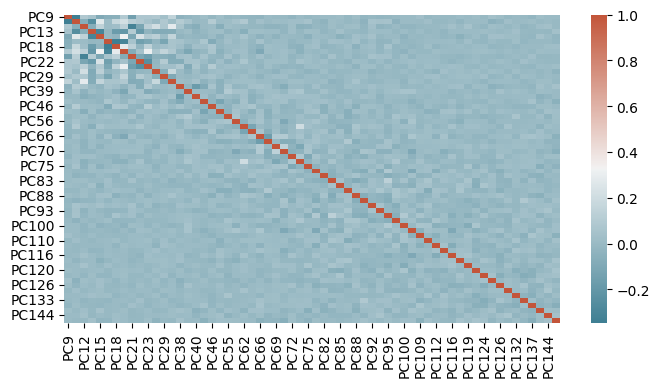

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corrmat, cmap=cmap, annot=False)

Group by yardımıyla ortalama değerlerine bakılarak sektöre bazlı incelemenin faydalı olabileceğini düşünddüm

In [12]:
grouped_data = pd.concat([filtered_x, y], axis=1).groupby('sectorType')[filtered_x.columns].mean().reset_index()
grouped_data

,sectorType,PC9,PC10,PC12,PC13,PC15,PC17,PC18,PC19,PC21,PC22,PC23,PC28,PC29,PC31,PC38,PC39,PC40,PC45,PC46,PC47,PC55,PC56,PC62,PC63,PC66,PC67,PC69,PC70,PC72,PC74,PC75,PC78,PC82,PC83,PC85,PC86,PC88,PC91,PC92,PC93,PC95,PC96,PC100,PC103,PC109,PC110,PC112,PC114,PC116,PC117,PC119,PC120,PC124,PC125,PC126,PC131,PC132,PC133,PC137,PC143,PC144,PC146
0,F,-0.178272,0.057739,-0.032285,0.036894,0.114969,0.021063,-0.206103,-0.057296,0.027139,-0.013077,-0.085749,-0.010354,-0.151157,0.060722,-0.058667,0.064463,0.027185,-0.081967,-0.088428,-0.048403,-0.022493,-0.048077,0.026701,0.051027,0.027482,-0.045719,0.019534,-0.043270,0.064908,0.050994,-0.043627,-0.055507,0.028874,0.001461,-0.030173,-0.014830,0.054012,0.009396,-0.007964,0.010330,-0.006072,-0.011399,0.027790,0.033883,0.013822,-0.013167,-0.012846,0.009572,-0.008469,-0.008111,0.005433,0.012090,-0.030071,-0.004297,0.019998,0.008393,-0.003733,0.017373,0.009402,-0.001040,-0.009149,-0.002424
1,H,0.116481,-0.054674,0.049782,0.043188,-0.115729,0.041136,0.082094,-0.018897,0.038776,-0.013381,0.012676,0.037420,0.050428,-0.037448,0.084481,-0.026323,-0.089314,0.006649,0.087883,0.047476,0.026119,0.051094,0.003461,-0.048199,0.002666,0.044885,-0.032865,0.009595,-0.046338,0.007363,0.043278,0.028006,-0.027943,-0.008732,0.026968,-0.018846,-0.017087,-0.001251,0.007855,0.022082,-0.020882,0.030864,-0.037772,-0.015234,-0.025002,0.021573,0.022071,-0.002263,-0.010074,-0.011271,0.011580,-0.023688,0.001335,0.018730,-0.001384,0.009964,-0.005878,-0.018775,-0.007661,0.009998,0.007610,0.006607
2,T,0.044720,0.011779,-0.036355,-0.113535,0.034089,-0.090356,0.133168,0.101669,-0.094374,0.037256,0.088688,-0.044905,0.112822,-0.018684,-0.056796,-0.040650,0.104059,0.093250,-0.024469,-0.012419,-0.012057,-0.018437,-0.039096,0.010225,-0.038852,-0.011795,0.026250,0.039797,-0.010196,-0.075833,-0.011948,0.026727,0.006822,0.011686,-0.003670,0.047939,-0.041759,-0.009932,-0.002111,-0.047270,0.040030,-0.033427,0.023424,-0.019200,0.021281,-0.016795,-0.017974,-0.008586,0.026311,0.027714,-0.024808,0.021433,0.035921,-0.023595,-0.023120,-0.026043,0.013825,0.007146,-0.000008,-0.014179,-0.000234,-0.007177


In [15]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## MODEL VE PARAMETRE SEÇİMİ

y değerleri için label encode ya da one hot encode işlemi yapabiliriz. Ama bu işlemden önce merak ettiğim husus ağaç algoritmalarının nasıl skor vereceğidir. Önce merakımızı giderelim. Daha önce bir kaggle yarışması için hazırlamış olduğum bir fonksiyon yardımıyla hızlı bir model seçimi ve parametre optimizasyon işlemini yapalım

Örnek için bir model kuralım:

In [13]:
knn_params = {"n_neighbors": range(2, 50)}

xgboost_params = {"learning_rate": [0.1],
                  "max_depth": [4,5,6],
                  "n_estimators": [50,60,70],
                  "colsample_bytree": [0.5],
                  "objective": ['multi:softmax'],
                  "num_class":[8]}

dtree_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [10, 11, None],
             "max_features": [7, 8, "sqrt"],
             "min_samples_split": [17,18,19],
             "n_estimators": [220,230,240]}

lightgbm_params = {"learning_rate": [0.01,0.1],
                   "n_estimators": [400,500],
                   "colsample_bytree": [0.7, 1]}
svc_params = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("DecisionTree", DecisionTreeClassifier(), dtree_params),
               ("RF", RandomForestClassifier(max_features='sqrt'), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(verbose = -1), lightgbm_params),
               ('SVC', SVC(), svc_params)]

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
  """
  Grid search ile daha önce belirlenen parametreler ile hiperparametre optimizasyonu yapılıyor.
  """
  print("Hyperparameter Optimization....")
  best_models = {}
  for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
  return best_models

In [18]:
best_model = hyperparameter_optimization(filtered_x,y,scoring="accuracy")

Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.5212
accuracy (After): 0.5295
KNN best params: {'n_neighbors': 4}

########## CART ##########
accuracy (Before): 0.5372
accuracy (After): 0.5662
CART best params: {'max_depth': 4, 'min_samples_split': 2}

########## RF ##########
accuracy (Before): 0.69
accuracy (After): 0.6693
RF best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 17, 'n_estimators': 240}

########## XGBoost ##########
accuracy (Before): 0.697
accuracy (After): 0.6934
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 70, 'num_class': 8, 'objective': 'multi:softmax'}

########## LightGBM ##########
accuracy (Before): 0.7027
accuracy (After): 0.7074
LightGBM best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'n_estimators': 500}

########## SVC ##########
accuracy (Before): 0.682
accuracy (After): 0.7054
SVC best params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


Çıktılara baktığımızda en yüksek accuracy değerini lightgbm modelinden alıyoruz. Parametrelerler yeterli oynama yapılırsa bu skor daha da yükselebilir. Ama şu anlık lightgbm ya da SVC bizim için yeterlidir.

Lightgbm i seçelim ve modelimizi kuralım.

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Veriyi train ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(filtered_x, y, test_size=0.3, random_state=42)

# LightGBM modelini tanımlama
lgbm_model = LGBMClassifier(colsample_bytree=1, learning_rate=0.1, n_estimators=500,verbose=-1)

# Modeli eğitme
lgbm_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred = lgbm_model.predict(X_test)

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Sonuçları yazdırma
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

LGBMClassifier(colsample_bytree=1, n_estimators=500, verbose=-1)

Accuracy: 0.7122222222222222
Precision: 0.708934772479165
Recall: 0.7122222222222222
F1 Score: 0.7063881027857967


Aşağıda modelimizin yanlış tahmin ettiği 259 değeri görelim. Bu değerler aslında 259 şirketi temsil etmektedir. Şöyle ki bu 259 şirketten bir tanesini örnek olarak alalım. Bu şirket teknoloji sektöründe olmasına rağmen modelimiz onu sağlık sektöründe göstermiştir. Bu durumda bu şirketin aylık değerleri sağlık sektöründen etkilenmekte hatta zaman zaman sağlık sektörüymüş gibi hareket etmektedir.

In [18]:
results_df = pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

# Hatalı tahmin edilen satırları seçme
misclassified_rows = results_df[results_df['Real'] != results_df['Predicted']]

print("Hatalı Tahmin Edilen Satırlar:")
print(misclassified_rows)

Hatalı Tahmin Edilen Satırlar:
     Real Predicted
2937    T         H
51      F         H
2422    T         F
2295    T         F
2978    T         H
...   ...       ...
2439    T         H
2560    T         F
1713    H         F
1477    H         F
2656    T         H

[259 rows x 2 columns]


Aslında aklımda olan fikir tsfresh kullanmadan sektör tipi için one hot encode yapıldıktan sonra her sektör için bir model kurmak ve bunun üzerinden benzerlik problemine çözüm getirmekti. Aykırı değerler tespit edilip sonrasında modele verilerek özellikle aykırı değerler üzerinde analiz yapılmış olacaktı. Sonrasında gelen her veri için bir fonksiyon oluşturulacak fonksiyon sonrası çıktı ve ay ay tahminler yer alacaktı. Bir sonraki ayın tahmini ARIMA kullanarak ve şirketin kurulma tarihine bağlı olarak sadece lineer regresyon kullanarak yapılacaktı. Ancak bu proje biraz zaman alacağından ve bu yazıyı pazartesi yazabildiğimden dolayı...

## NOT

İsmail Hocam son kısmı için yeterli zaman ayıramadım kolay gelsin iyi okumalar...